# 导入所需库

In [15]:
import numpy as np
import time

# 数据准备

## 加载数据集

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()

## 数据探索

In [17]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [18]:
data = digits.data
labels = digits.target
data , labels

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 array([0, 1, 2, ..., 8, 9, 8]))

## 展示数字

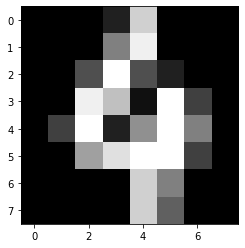

4


In [19]:
#展示数字
from matplotlib import pyplot as plt 

def showImage(image):
    plt.gray()
    plt.imshow(digits.images[i])
    plt.show()
    
i=100   
showImage(data[i])
print(labels[i])

## 分割数据集

In [233]:
from sklearn.model_selection import train_test_split
train_x , test_x , train_y , test_y = train_test_split(data,labels,test_size=0.25, random_state=33)

## 另一个数据集

In [20]:
import pandas as pd
trainData = pd.read_csv('mnist_train.csv')
testData = pd.read_csv('mnist_test.csv')
train_x = np.array(trainData)[:,1:]
train_y = np.array(trainData)[:,0]
test_x = np.array(testData)[:,1:]
test_y = np.array(testData)[:,0]

## 观察输入数据的格式

In [21]:
print('train_x:',train_x.shape)
print('train_y:',train_y.shape)
print('test_x:',test_x.shape)
print('test_y:',test_y.shape)

train_x: (59999, 784)
train_y: (59999,)
test_x: (9999, 784)
test_y: (9999,)


# 数据预处理

## 归一化

In [14]:
def normalization(data):
    newdata=np.zeros((data.shape[0],data.shape[1]))
    colNum = data.shape[1]
    for col in range(colNum):
        MAX = np.max(data[:,col])
        MIN = np.min(data[:,col])
        for row in range(data.shape[0]):
            newdata[row][col] = (data[row][col]-MIN)/(MAX-MIN)
    return newdata

## 标准化

In [15]:
def standardization(data):
    newdata=np.zeros((data.shape[0],data.shape[1]))
    colNum = data.shape[1]
    for col in range(colNum):
        mean = np.mean(data[:,col])
        std = np.std(data[:,col])
        for row in range(data.shape[0]):
            newdata[row][col] = (data[row][col]-mean)/std
    return newdata

## 二值化

In [115]:
def binary(data):
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j]>0:
                data[i][j]=1
            else:
                data[i][j]=0.01
    return data
    

In [116]:
train_x = normalization(train_x)
test_x = normalization(test_x)
train_x.shape

<ipython-input-14-f11de6d1075a>:8: RuntimeWarning: invalid value encountered in double_scalars
  newdata[row][col] = (data[row][col]-MIN)/(MAX-MIN)


(1347, 64)

# 激活函数部分

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 网络结构

In [27]:
# 创建神经网络类，以便于实例化成不同的实例
class NeuralNetwork:
    def __init__(self,epoch_num, input_nodes, hidden_nodes, output_nodes=10, learning_rate=0.001):
        # 初始化参数
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.epoch_num = epoch_num
        #loss列表
        self.Losses =[]
        # 定义连接权
        # 定义输入层与隐藏层之间的初始权重参数  w-input-hidden
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        # 定义隐藏层与输出层之间的初始权重参数  w-hidden-output
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        # 定义输入层与隐藏的bias
        self.bih = np.ones((self.hnodes, 1))
        # 定义隐藏层与输出层的bias
        self.bho = np.ones((self.onodes, 1))
        # 学习率
        self.lr = learning_rate
        # 定义激活函数sigmoid
        self.activation_function = sigmoid
        pass

    def forward_backward(self,iter_count, input_list, target_list):
        # 输入层的矩阵
        inputs = np.array(input_list, ndmin=2).T
        # 目标矩阵
        targets = np.array(target_list, ndmin=2).T
        # 隐藏层的输入
        hidden_inputs = np.dot(self.wih, inputs) + self.bih  # 输入的 x 乘上 input-hidden的权重
        # 隐藏层的输出
        hidden_outputs = self.activation_function(hidden_inputs)  # 激活函数sigmoid判断隐藏层的结果
        # 输出层的输入
        final_inputs = np.dot(self.who, hidden_outputs) + self.bho  # 隐藏层输出的 b 乘上 hidden-output的权重
        # 输出层的输出
        final_outputs = self.activation_function(final_inputs)
        # 输出层的错误
        output_errors =  final_outputs-targets # (y-y')
        # Loss
        loss=0.5*(final_outputs-targets)**2
        if(iter_count%200==0):
            self.Losses.append(loss.mean())
        # 隐藏层的错误
        hidden_errors = np.dot(self.who.T, (output_errors * final_outputs * (1 - final_outputs)))  # 相当于 W-h-o * g
        # 更新迭代初始权重，公式为权重更新公式，原理为导数、梯度下降。
        # 输出层与隐藏层权重值改变  = 学习率(lr)* 输出层神经元梯度项(y'(1-y')(y-y'))* 隐藏层的输出(b)
        # 隐藏层与输出层权重值改变  = 学习率(lr)* 隐藏层神经元梯度项(b(1-b)(Who*g))* 输入层的输入(x)
        self.who -= self.lr * np.dot((output_errors * final_outputs * (1 - final_outputs)),np.transpose(hidden_outputs))
        self.bho -= self.lr * (output_errors * final_outputs * (1 - final_outputs))
        self.bih -= self.lr * (hidden_errors * hidden_outputs * (1 - hidden_outputs))
        self.wih -= self.lr * np.dot((hidden_errors * hidden_outputs * (1 - hidden_outputs)),(np.transpose(inputs)))
        pass
    
    
    def train(self,train_x,train_y):
        print("开始训练:")
        for epoch in range(self.epoch_num):
            print("第%d个epoch:"%(epoch+1))
            start = time.perf_counter()
            for i in range(len(train_x)):
                scale = len(train_x)
                inputs = ( train_x[i]/ 255 * 0.99) + 0.01 #归一化
                y = train_y[i]
                targets = np.zeros(output_nodes) + 0.01 #防止由于0值像素引起梯度归零
                targets[y] = 0.99
                self.forward_backward(i,inputs, targets)
                #显示进度条模块
                if (i % 100 == 0):
                    a = "*" * (i // 1200)
                    b = "." * ((scale - i) // 1200)
                    c = (i / scale) * 100
                    dur = time.perf_counter() - start
                    print("\r{:^3.0f}%[{}->{}]{:.2f}s".format(c, a, b, dur), end="")
            print("\n第%d个epoch结束!"%(epoch+1))


    
    def predict(self, inputs_list):
        # 输入层的输入
        inputs = np.array(inputs_list, ndmin=2).T
        # 输入-隐藏的权重*输入层的输入 得到 隐藏层的输入
        hidden_inputs = np.dot(self.wih, inputs) + self.bih
        # 隐藏层的输入 通过 激活函数 得到 隐藏层的输出
        hidden_outputs = self.activation_function(hidden_inputs)
        # 隐藏-输出的权重*隐藏层的输出 得到 输出层的输入
        final_inputs = np.dot(self.who, hidden_outputs) + self.bho
        # 输出层的输入 通过 激活函数 得到 输出层的输出
        final_outputs = self.activation_function(final_inputs)
        return np.argmax(final_outputs)
    
    def test(self,test_x,test_y):
        correct=0
        for i in range(len(test_x)):
            correct_label = test_y[i]
            inputs = (test_x[i]/ 255 * 0.99) + 0.01 #归一化
            pre_label = net.predict(inputs)
            correct = correct+1 if pre_label==correct_label else correct
        print("正确率为:",str(correct/len(test_x)*100) +'%')

# 定义参数以实例化网络模型

In [38]:
# 定义epoch
epoch = 5
# 输入层神经元个数 32x32=784
input_nodes = 784 
# 隐藏层神经元数量
hidden_nodes = 200
# 输出层神经元数量
output_nodes = 10
# 定义学习率
learning_rate = 0.1
# 创建神经网络实例
net = NeuralNetwork(epoch,input_nodes, hidden_nodes, output_nodes, learning_rate)

# 训练

In [39]:
net.train(train_x,train_y)

开始训练:
第1个epoch:
100%[*************************************************->]18.24s
第1个epoch结束!
第2个epoch:
100%[*************************************************->]19.25s
第2个epoch结束!
第3个epoch:
100%[*************************************************->]19.36s
第3个epoch结束!
第4个epoch:
100%[*************************************************->]19.70s
第4个epoch结束!
第5个epoch:
100%[*************************************************->]19.41s
第5个epoch结束!


# 测试

In [40]:
net.test(test_x,test_y)

正确率为: 96.95969596959696%


# 尝试多组参数

## 第一组参数

In [41]:
# 定义epoch
epoch = 3
# 输入层神经元个数 32x32=784
input_nodes = 784 
# 隐藏层神经元数量
hidden_nodes = 100
# 输出层神经元数量
output_nodes = 10
# 定义学习率
learning_rate = 0.1
# 创建神经网络实例
net = NeuralNetwork(epoch,input_nodes, hidden_nodes, output_nodes, learning_rate)
net.train(train_x,train_y)
net.test(test_x,test_y)

开始训练:
第1个epoch:
100%[*************************************************->]11.16s
第1个epoch结束!
第2个epoch:
100%[*************************************************->]10.94s
第2个epoch结束!
第3个epoch:
100%[*************************************************->]10.32s
第3个epoch结束!
正确率为: 96.24962496249626%


## 第二组参数

In [42]:
# 定义epoch
epoch = 6
# 输入层神经元个数 32x32=784
input_nodes = 784 
# 隐藏层神经元数量
hidden_nodes = 200
# 输出层神经元数量
output_nodes = 10
# 定义学习率
learning_rate = 0.1
# 创建神经网络实例
net = NeuralNetwork(epoch,input_nodes, hidden_nodes, output_nodes, learning_rate)
net.train(train_x,train_y)
net.test(test_x,test_y)

开始训练:
第1个epoch:
100%[*************************************************->]18.37s
第1个epoch结束!
第2个epoch:
100%[*************************************************->]18.81s
第2个epoch结束!
第3个epoch:
100%[*************************************************->]18.74s
第3个epoch结束!
第4个epoch:
100%[*************************************************->]18.19s
第4个epoch结束!
第5个epoch:
100%[*************************************************->]18.07s
第5个epoch结束!
第6个epoch:
100%[*************************************************->]18.30s
第6个epoch结束!
正确率为: 97.24972497249725%


## 第三组参数

In [43]:
# 定义epoch
epoch = 10
# 输入层神经元个数 32x32=784
input_nodes = 784 
# 隐藏层神经元数量
hidden_nodes = 150
# 输出层神经元数量
output_nodes = 10
# 定义学习率
learning_rate = 0.1
# 创建神经网络实例
net = NeuralNetwork(epoch,input_nodes, hidden_nodes, output_nodes, learning_rate)
net.train(train_x,train_y)
net.test(test_x,test_y)

开始训练:
第1个epoch:
100%[*************************************************->]15.03s
第1个epoch结束!
第2个epoch:
100%[*************************************************->]15.07s
第2个epoch结束!
第3个epoch:
100%[*************************************************->]15.04s
第3个epoch结束!
第4个epoch:
100%[*************************************************->]15.50s
第4个epoch结束!
第5个epoch:
100%[*************************************************->]15.24s
第5个epoch结束!
第6个epoch:
100%[*************************************************->]14.58s
第6个epoch结束!
第7个epoch:
100%[*************************************************->]14.64s
第7个epoch结束!
第8个epoch:
100%[*************************************************->]15.45s
第8个epoch结束!
第9个epoch:
100%[*************************************************->]14.71s
第9个epoch结束!
第10个epoch:
100%[*************************************************->]15.10s
第10个epoch结束!
正确率为: 97.53975397539753%
